## import thư viện

In [1]:
!pip install -Uqq underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 95.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 11.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from itertools import chain
from collections import Counter
from underthesea import word_tokenize
import re
import unicodedata
import string
import matplotlib.pyplot as plt
import seaborn as sns
import underthesea
from bs4 import BeautifulSoup
from underthesea import word_tokenize
import logging
import os
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode


# Tiền xử lý dữ liệu (Preprocessing)

In [5]:
data = pd.read_excel("/kaggle/input/data-final/data_final.xlsx")
data.head(10)

,Unnamed: 0,old_data,label
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,4,Nhỏ gọn gê,1
5,5,"ổ cứng chạy rất nhanh, nhỏ hơn mình nghĩ nhưng...",1
6,6,Sản phẩm chất lượng chính hãng. Rất hài lòng. ...,1
7,7,"Hàng giao nhanh, xai rất ổn định. Mình xài cũn...",4
8,8,"Ổ cứng nhỏ gọn và tốc độ truyền dữ liệu nhanh,...",1
9,9,"Tốc độ nhanh, nhỏ gọn hơn nhiều so với mình tư...",1


In [6]:
data["label"].value_counts()

label
1    14910
2     4144
0     4074
4     2470
3      931
5      382
Name: count, dtype: int64

data.info()

In [7]:
null_count = data.isnull().sum()
null_count

Unnamed: 0    0
old_data      0
label         0
dtype: int64

In [8]:
data.drop(columns=['Unnamed: 0'], inplace=True)

### DATA PROCESSING

Mục đích: Làm sạch và chuẩn hóa văn bản tiếng Việt (đánh giá sản phẩm) để phù hợp cho phân tích và học máy. Xử lý các vấn đề như HTML, ký tự đặc biệt, teencode, lỗi dấu và stopwords.

Hàm xử lý văn bản (preprocess_text):
Thực hiện các bước:
- Xóa HTML: Loại bỏ mã HTML bằng BeautifulSoup.
- Chuẩn hóa Unicode: Đảm bảo văn bản ở định dạng UTF-8.
- Chuẩn hóa dấu: Sửa lỗi gõ dấu tiếng Việt (ví dụ: oà → oà).
- Chuyển chữ thường: Đưa văn bản về dạng chữ thường.
- Xóa ký tự đặc biệt: Loại bỏ emoji, dấu câu,...
- Tách từ: Sử dụng underthesea để tách từ tiếng Việt.
- Thay teencode: Thay từ viết tắt (như sp → sản phẩm) dựa trên từ điển.
- Xóa stopwords: Loại bỏ từ không mang ý nghĩa (như và, là).
- Lọc từ xuất hiện từ 3 lần trở lên.


In [9]:
import pandas as pd
import re
import os
import logging
import unicodedata
from bs4 import BeautifulSoup
from underthesea import word_tokenize
from collections import Counter

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Hàm kiểm tra thư viện
def check_libraries():
    required_libraries = ['pandas', 'bs4', 'underthesea']
    for lib in required_libraries:
        try:
            __import__(lib)
        except ImportError:
            logging.error(f"Thư viện {lib} chưa được cài đặt. Vui lòng cài đặt bằng: pip install {lib}")
            raise

# Hàm xóa HTML code
def remove_html(text):
    if not isinstance(text, str):
        return ""
    try:
        return BeautifulSoup(text, "html.parser").get_text()
    except Exception as e:
        logging.warning(f"Lỗi khi xóa HTML: {e}")
        return text

# Hàm chuẩn hóa Unicode
def normalize_unicode(text):
    if not isinstance(text, str):
        return ""
    try:
        text = unicodedata.normalize('NFC', text)
        text = text.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')
        return text
    except Exception as e:
        logging.warning(f"Lỗi khi chuẩn hóa Unicode: {e}")
        return text

# Hàm chuẩn hóa kiểu gõ dấu tiếng Việt
def normalize_tone(text):
    if not isinstance(text, str):
        return ""
    try:
        text = unicodedata.normalize('NFC', text)
        replacements = {
            r'òa': 'oà', r'óa': 'oá', r'ỏa': 'oả', r'õa': 'oã', r'ọa': 'oạ',
            r'òe': 'oè', r'óe': 'oé', r'ỏe': 'oẻ', r'õe': 'oẽ', r'ọe': 'oẹ',
            r'uỳ': 'ùy', r'uý': 'úy', r'uỷ': 'ủy', r'uỹ': 'ũy', r'uỵ': 'ụy'
        }
        for pattern, replacement in replacements.items():
            text = re.sub(pattern, replacement, text)
        return text
    except Exception as e:
        logging.warning(f"Lỗi khi chuẩn hóa dấu: {e}")
        return text

# Hàm tải từ điển teencode
def load_teencode(file_path):
    teencode_dict = {}
    if not os.path.exists(file_path):
        logging.error(f"Tệp teencode {file_path} không tồn tại.")
        return teencode_dict
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = re.split(r'\s+', line)
                    if len(parts) < 2:
                        logging.warning(f"Dòng không hợp lệ trong teencode: {line}")
                        continue
                    abbr, full = parts[0], ' '.join(parts[1:])
                    teencode_dict[abbr.strip()] = full.strip()
        logging.info(f"Tải thành công {len(teencode_dict)} từ teencode.")
    except Exception as e:
        logging.error(f"Lỗi khi đọc tệp teencode: {e}")
    return teencode_dict

# Hàm tải danh sách stopwords
def load_stopwords(file_path):
    stopwords = set()
    if not os.path.exists(file_path):
        logging.error(f"Tệp stopwords {file_path} không tồn tại.")
        return stopwords
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = set(line.strip() for line in f if line.strip())
    except Exception as e:
        logging.error(f"Lỗi khi đọc tệp stopwords: {e}")
    logging.info(f"Tải thành công {len(stopwords)} stopwords.")
    return stopwords

# Hàm loại bỏ biểu tượng và ký tự đặc biệt
def remove_icons(text):
    if not isinstance(text, str):
        return ""
    try:
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F700-\U0001F77F"
            u"\U0001F780-\U0001F7FF"
            u"\U0001F800-\U0001F8FF"
            u"\U0001F900-\U0001F9FF"
            u"\U0001FA00-\U0001FA6F"
            u"\U0001FA70-\U0001FAFF"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r' ', text)
        text = re.sub(r'[^\w\sàáạảãâầấạẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    except Exception as e:
        logging.warning(f"Lỗi khi loại bỏ biểu tượng: {e}")
        return text

# Hàm loại bỏ ký tự lặp liên tiếp trong từ
def remove_repeated_chars(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'(.)\1+', r'\1', text)

# Hàm loại bỏ từ lặp lại liên tiếp
def remove_repeated_words(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'\b(\w+)\s+\1(?:\s+\1)*\b', r'\1', text, flags=re.IGNORECASE)

# Hàm tách từ và thêm dấu
def add_tone_and_split_words(text):
    if not isinstance(text, str):
        return ""
    try:
        tokenized = word_tokenize(text, format="text")
        if not tokenized.strip():
            logging.warning(f"Văn bản rỗng sau khi tách từ: {text}")
            return text
        return tokenized
    except Exception as e:
        logging.warning(f"Lỗi khi tách từ: {e} - Văn bản: {text}")
        return text

# Hàm thay thế teencode
def replace_teencode(text, abbreviation_dict):
    if not isinstance(text, str):
        return ""
    for abbr, full in sorted(abbreviation_dict.items(), key=lambda x: len(x[0]), reverse=True):
        pattern = r'\b' + re.escape(abbr) + r'\b'
        text = re.sub(pattern, full, text, flags=re.IGNORECASE)
    return text

# Hàm xử lý văn bản chính
def preprocess_text(text, abbreviation_dict, stopwords, steps=None):
    if not isinstance(text, str):
        text = ""
    if steps is None:
        steps = ['html', 'unicode', 'tone', 'lower', 'icons', 'repeated_chars', 'repeated_words', 'tokenize', 'teencode', 'stopwords']
    
    logging.debug(f"Input text: {text}")
    if 'html' in steps:
        text = remove_html(text)
        logging.debug(f"After html: {text}")
        if not text.strip():
            logging.warning("Văn bản rỗng sau bước xóa HTML")
            return ""
    if 'unicode' in steps:
        text = normalize_unicode(text)
        logging.debug(f"After unicode: {text}")
        if not text.strip():
            logging.warning("Văn bản rỗng sau bước chuẩn hóa Unicode")
            return ""
    if 'tone' in steps:
        text = normalize_tone(text)
        logging.debug(f"After tone: {text}")
        if not text.strip():
            logging.warning("Văn bản rỗng sau bước chuẩn hóa dấu")
            return ""
    if 'lower' in steps:
        text = text.lower()
        logging.debug(f"After lower: {text}")
    if 'icons' in steps:
        text = remove_icons(text)
        logging.debug(f"After icons: {text}")
    if 'repeated_chars' in steps:
        text = remove_repeated_chars(text)
        logging.debug(f"After repeated_chars: {text}")
    if 'repeated_words' in steps:
        text = remove_repeated_words(text)
        logging.debug(f"After repeated_words: {text}")
    if 'tokenize' in steps:
        text = add_tone_and_split_words(text)
        logging.debug(f"After tokenize: {text}")
    if 'teencode' in steps:
        text = replace_teencode(text, abbreviation_dict)
        logging.debug(f"After teencode: {text}")
    if 'stopwords' in steps:
        words = text.split()
        words = [word for word in words if word not in stopwords]
        text = ' '.join(words)
        logging.debug(f"After stopwords: {text}")
    
    return text

def remove_rare_words(data, column='cleaned_data', min_count=3):
    all_words = []
    for text in data[column].dropna().astype(str).values:
        all_words.extend(text.split())
    word_freq = Counter(all_words)

    common_words = set([word for word, freq in word_freq.items() if freq > min_count])
    logging.info(f"Số từ xuất hiện trên {min_count} lần: {len(common_words)}")

    def filter_line(text):
        if not isinstance(text, str):
            return ""
        return ' '.join([word for word in text.split() if word in common_words])

    data[column] = data[column].apply(filter_line)
    return data, common_words

# Hàm chính để xử lý dữ liệu
def main(input_file, teencode_file, stopword_file, output_file='processed_data.xlsx'):
    check_libraries()
    
    abbreviation_dict = load_teencode(teencode_file)
    stopwords = load_stopwords(stopword_file)
    
    if not os.path.exists(input_file):
        logging.error(f"Tệp dữ liệu {input_file} không tồn tại.")
        return
    try:
        data = pd.read_excel(input_file)
        logging.info(f"Đọc thành công dữ liệu với {len(data)} mẫu.")
    except Exception as e:
        logging.error(f"Lỗi khi đọc tệp Excel: {e}")
        return
    
    # Thử nghiệm với một mẫu nhỏ
    test_text = data['old_data'].iloc[0]
    logging.info(f"Thử nghiệm tiền xử lý với mẫu: {test_text}")
    processed_text = preprocess_text(test_text, abbreviation_dict, stopwords)
    logging.info(f"Kết quả sau tiền xử lý: {processed_text}")
    
    # Xử lý toàn bộ dữ liệu
    data['cleaned_data'] = data['old_data'].apply(
        lambda x: preprocess_text(x, abbreviation_dict, stopwords)
    )
    
    data, kept_words = remove_rare_words(data, column='cleaned_data', min_count=3)
    
    try:
        data.to_excel(output_file, index=False)
        logging.info(f"Lưu dữ liệu đã xử lý vào {output_file}")
    except Exception as e:
        logging.error(f"Lỗi khi lưu tệp: {e}")

if __name__ == "__main__":
    input_file = '/kaggle/input/data-final/data_final.xlsx'
    teencode_file = '/kaggle/input/data-final/teencode.txt'
    stopword_file = '/kaggle/input/data-final/stopwords_vi.txt'
    output_file = 'processed_data.xlsx'
    
    main(input_file, teencode_file, stopword_file, output_file)

/tmp/ipykernel_31/669721238.py:28: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, "html.parser").get_text()


In [10]:
data = pd.read_excel("/kaggle/working/processed_data.xlsx")
data.head()

,Unnamed: 0,old_data,label,cleaned_data
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0,shop giao sản_phẩm sử_dụng không hài_lòng sản_...
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4,đóng_gói cẩn_thận sp nhỏ gọn hài_lòng cám_ơn tiki
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1,sản_phẩm nhỏ gọn giao hàng nhanh
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1,sản_phẩm chuẩn so với quảng_cáo
4,4,Nhỏ gọn gê,1,nhỏ gọn


Xóa các dòng ở cột cleaned_data null

In [11]:
data['cleaned_data'].isnull().sum()

5

In [12]:
data.dropna(inplace = True)

In [13]:
data['cleaned_data'].isnull().sum()

0

In [14]:
data.head(10)

,Unnamed: 0,old_data,label,cleaned_data
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0,shop giao sản_phẩm sử_dụng không hài_lòng sản_...
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4,đóng_gói cẩn_thận sp nhỏ gọn hài_lòng cám_ơn tiki
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1,sản_phẩm nhỏ gọn giao hàng nhanh
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1,sản_phẩm chuẩn so với quảng_cáo
4,4,Nhỏ gọn gê,1,nhỏ gọn
5,5,"ổ cứng chạy rất nhanh, nhỏ hơn mình nghĩ nhưng...",1,ổ cứng chạy nhanh nhỏ hơn nghĩ bền cầm êm
6,6,Sản phẩm chất lượng chính hãng. Rất hài lòng. ...,1,sản_phẩm chất_lượng hãng hài_lòng đúng hàng
7,7,"Hàng giao nhanh, xai rất ổn định. Mình xài cũn...",4,hàng giao nhanh xai ổn_định xài chép film 10 m...
8,8,"Ổ cứng nhỏ gọn và tốc độ truyền dữ liệu nhanh,...",1,ổ cứng nhỏ gọn tốc_độ truyền dữ_liệu nhanh dùn...
9,9,"Tốc độ nhanh, nhỏ gọn hơn nhiều so với mình tư...",1,tốc_độ nhanh nhỏ gọn hơn so với tưởng_tượng


# Khám phá dữ liệu (EDA)

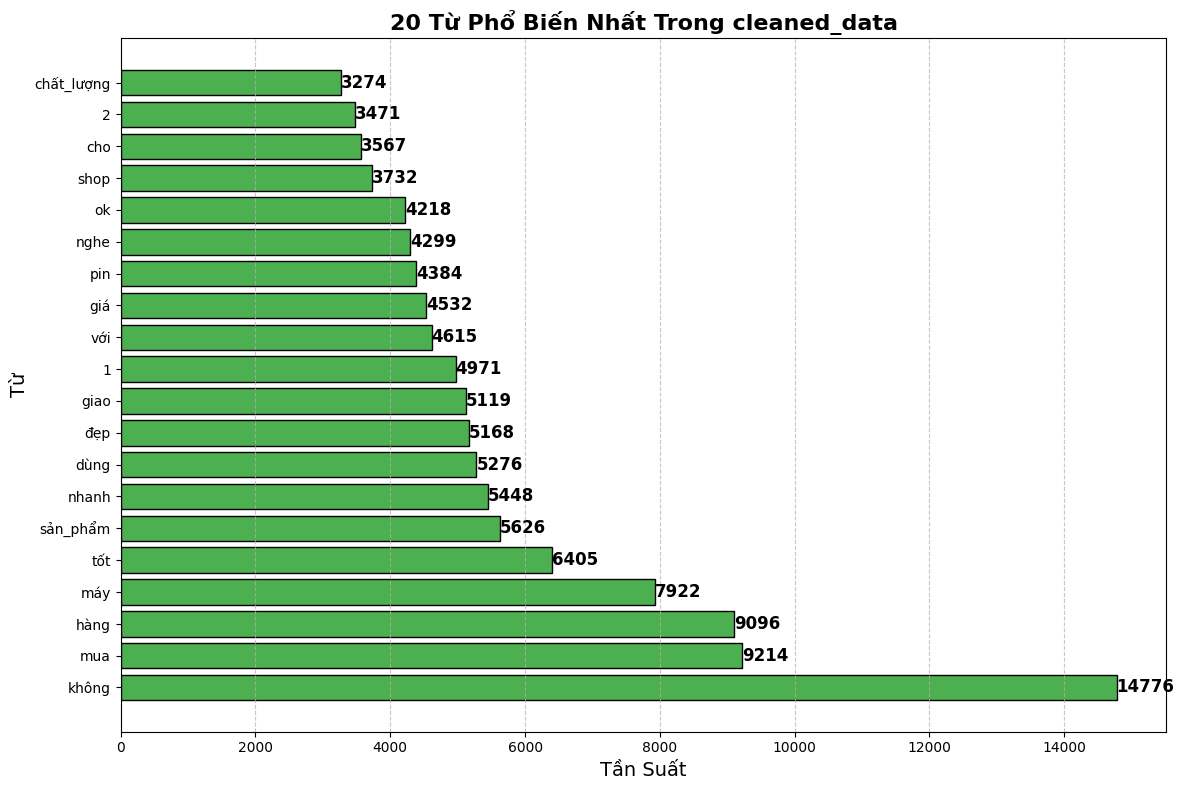

In [15]:
all_reviews = ' '.join(data['cleaned_data'].fillna('').astype(str).tolist())
words = word_tokenize(all_reviews.lower())
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 8))
bars = plt.barh(words, counts, color='#4CAF50', edgecolor='black')
plt.title('20 Từ Phổ Biến Nhất Trong cleaned_data', fontsize=16, fontweight='bold')
plt.xlabel('Tần Suất', fontsize=14)
plt.ylabel('Từ', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    plt.annotate(f'{bar.get_width()}',
                 (bar.get_width(), bar.get_y() + bar.get_height()/2),
                 ha='left', va='center',
                 fontsize=12, fontweight='bold', color='black')
plt.tight_layout()
plt.show()

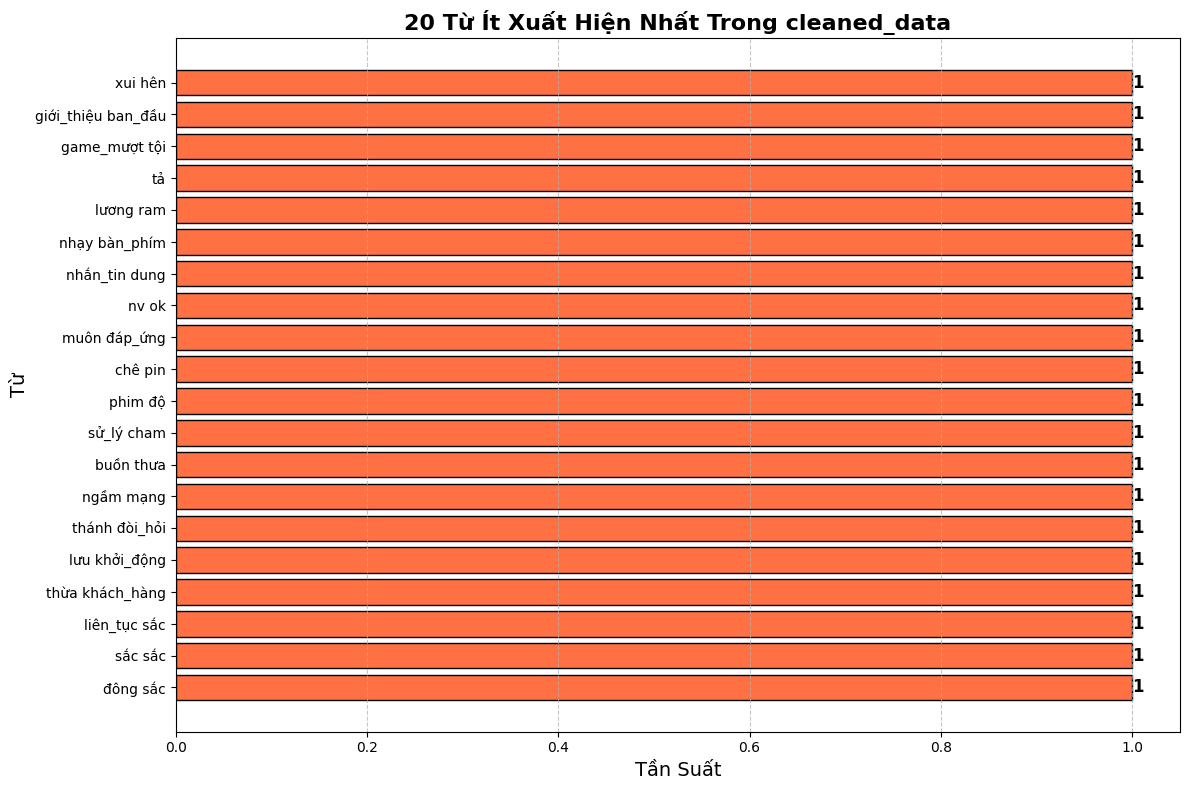

In [16]:
# Ghép toàn bộ dữ liệu cleaned_data và tokenize
all_reviews = ' '.join(data['cleaned_data'].fillna('').astype(str).tolist())
words = word_tokenize(all_reviews.lower())

# Đếm tần suất xuất hiện của mỗi từ
word_counts = Counter(words)

# Lấy 20 từ ít phổ biến nhất (có tần suất > 0)
least_common_words = word_counts.most_common()[:-21:-1]  # lấy từ cuối danh sách
words_least, counts_least = zip(*least_common_words)

# Vẽ biểu đồ ngang
plt.figure(figsize=(12, 8))
bars = plt.barh(words_least, counts_least, color='#FF7043', edgecolor='black')
plt.title('20 Từ Ít Xuất Hiện Nhất Trong cleaned_data', fontsize=16, fontweight='bold')
plt.xlabel('Tần Suất', fontsize=14)
plt.ylabel('Từ', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Thêm nhãn số lượng
for bar in bars:
    plt.annotate(f'{bar.get_width()}',
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='left', va='center',
                 fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


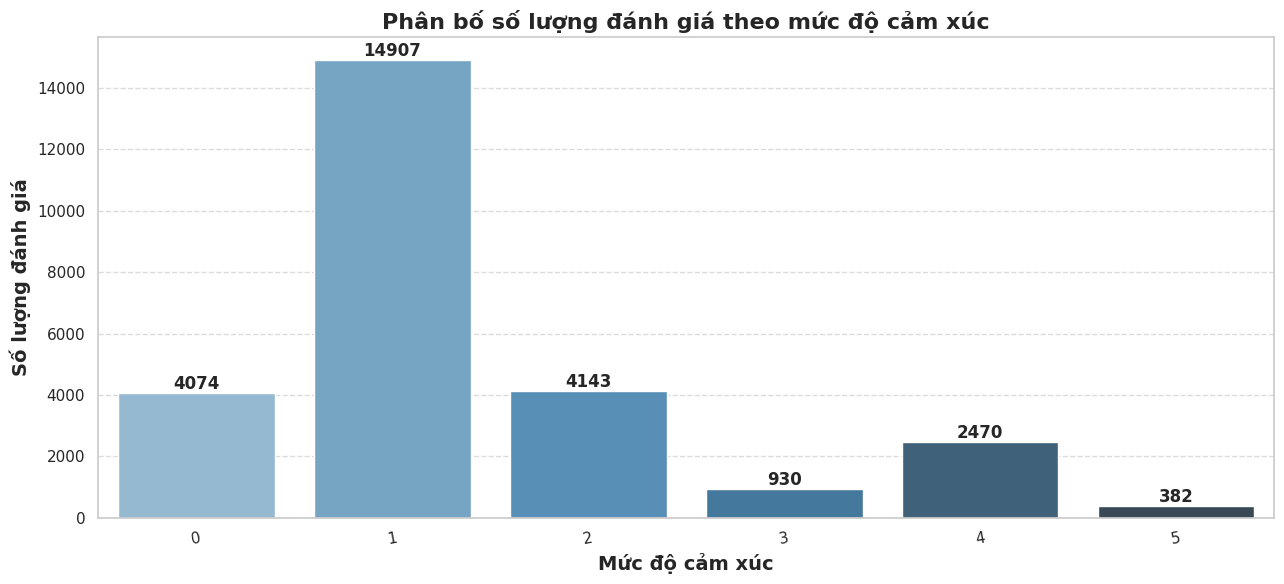

In [17]:


# Đếm số lượng theo label, đảm bảo đúng thứ tự từ 0–5
label_counts = data['label'].value_counts().sort_index()
labels = label_counts.index.tolist() 

# Thiết lập giao diện biểu đồ
sns.set(style="whitegrid")
plt.figure(figsize=(13, 6))

# Vẽ biểu đồ
bar_plot = sns.barplot(x=labels, y=label_counts.values, palette='Blues_d')

# Nhãn trục và tiêu đề
plt.xlabel('Mức độ cảm xúc', fontsize=14, fontweight='bold')
plt.ylabel('Số lượng đánh giá', fontsize=14, fontweight='bold')
plt.title('Phân bố số lượng đánh giá theo mức độ cảm xúc', fontsize=16, fontweight='bold')

# Tùy chỉnh nhãn x
bar_plot.set_xticklabels(labels, rotation=10, fontsize=11, ha='center')

# Thêm số lượng lên cột
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom',
                      fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


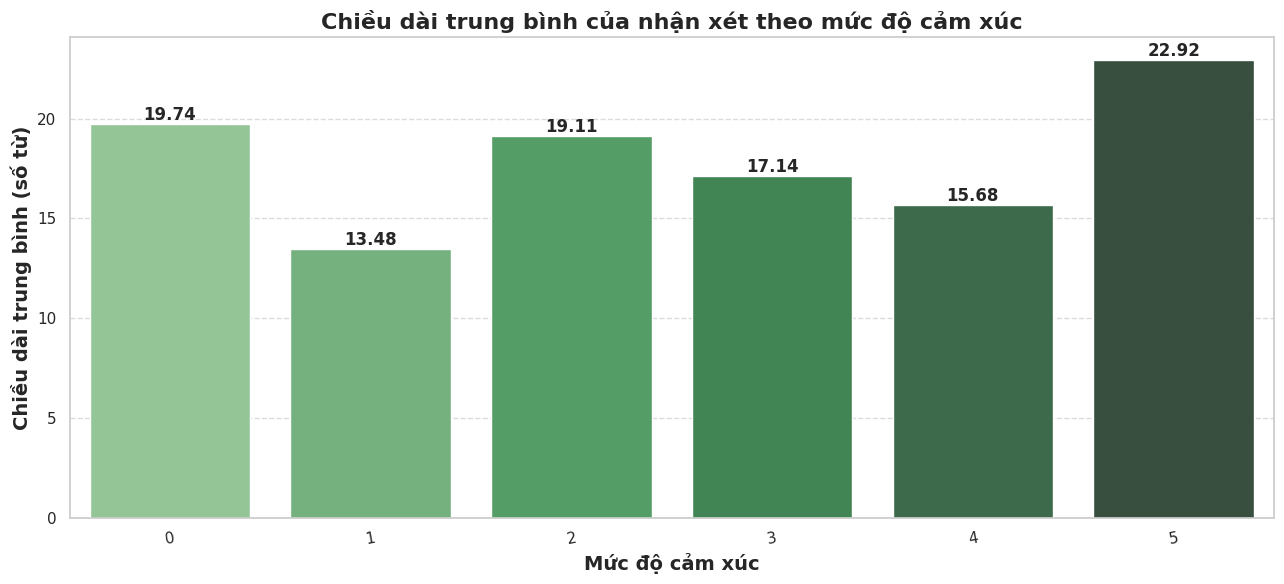

In [18]:
# Tính trung bình chiều dài (số từ) theo từng label
avg_length_by_label = data.groupby('label')['cleaned_data'].apply(lambda x: x.apply(lambda y: len(str(y).split())).mean()).sort_index()

# Gán nhãn cho các label
labels = label_counts.index.tolist() 

# Vẽ biểu đồ
sns.set(style="whitegrid")
plt.figure(figsize=(13, 6))
length_plot = sns.barplot(x=labels, y=avg_length_by_label.values, palette='Greens_d')

# Thiết lập nhãn trục và tiêu đề
plt.xlabel('Mức độ cảm xúc', fontsize=14, fontweight='bold')
plt.ylabel('Chiều dài trung bình (số từ)', fontsize=14, fontweight='bold')
plt.title('Chiều dài trung bình của nhận xét theo mức độ cảm xúc', fontsize=16, fontweight='bold')

# Tùy chỉnh hiển thị trục x
length_plot.set_xticklabels(labels, rotation=10, fontsize=11, ha='center')

# Thêm nhãn giá trị trên từng cột
for p in length_plot.patches:
    length_plot.annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom',
                         fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/1305785259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_longest_reviews['short_review'] = top_10_longest_reviews['cleaned_data'].apply(


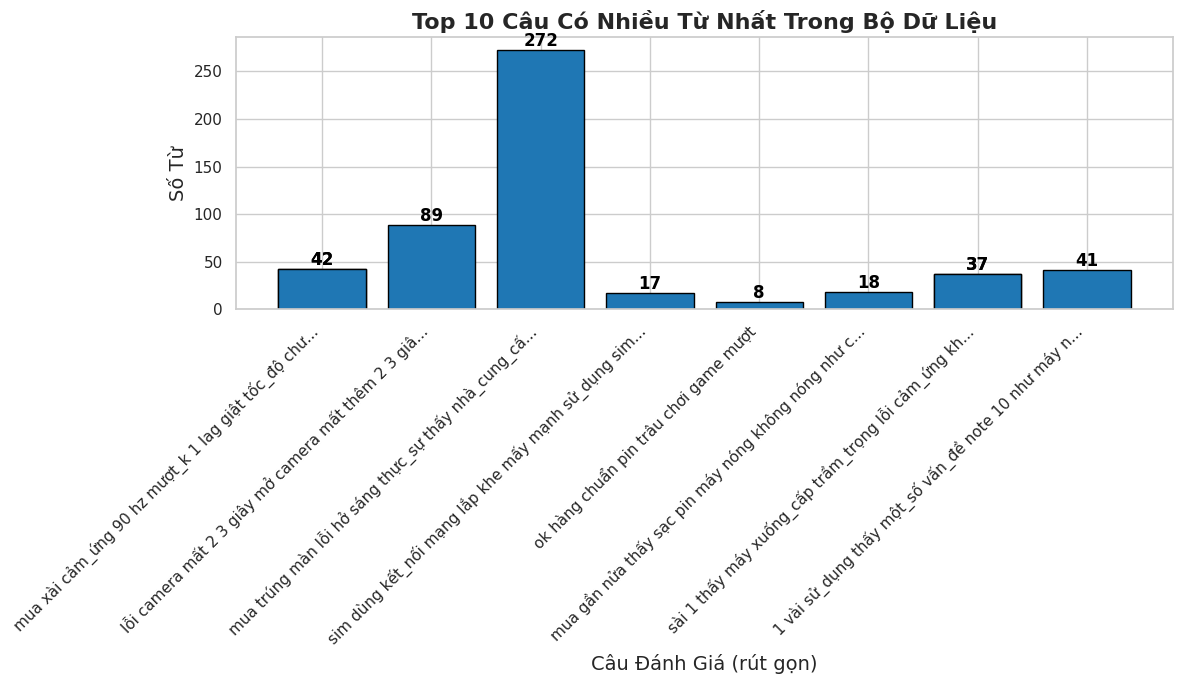

In [19]:
# Tính số từ của từng đánh giá mà không tạo cột 'word_count'
top_10_longest_reviews = data.apply(
    lambda x: len(str(x['cleaned_data']).split()), axis=1
)

# Lấy top 10 câu có số từ nhiều nhất mà không tạo cột 'word_count'
top_10_longest_reviews = data.iloc[top_10_longest_reviews.sort_values(ascending=False).index[:10]]

# Rút gọn nội dung đánh giá để hiển thị trên biểu đồ
max_length = 50
top_10_longest_reviews['short_review'] = top_10_longest_reviews['cleaned_data'].apply(
    lambda x: x[:max_length] + '...' if len(x) > max_length else x
)

# Vẽ biểu đồ thanh
plt.figure(figsize=(12, 7))
bars = plt.bar(top_10_longest_reviews['short_review'], top_10_longest_reviews.apply(
    lambda x: len(str(x['cleaned_data']).split()), axis=1), color='#1f77b4', edgecolor='black')

# Thiết lập tiêu đề và nhãn trục
plt.title('Top 10 Câu Có Nhiều Từ Nhất Trong Bộ Dữ Liệu', fontsize=16, fontweight='bold')
plt.xlabel('Câu Đánh Giá (rút gọn)', fontsize=14)
plt.ylabel('Số Từ', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Thêm nhãn trên từng thanh
for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


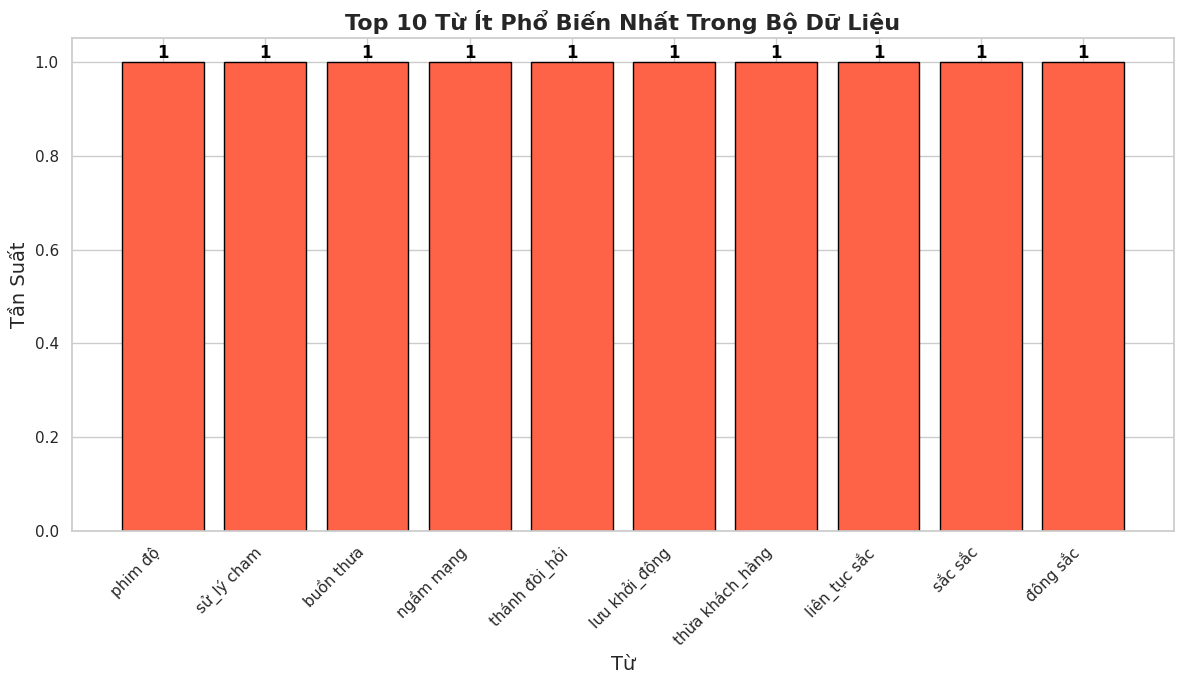

In [20]:
# Tokenize và đếm tần suất của các từ
all_reviews = ' '.join(data['cleaned_data'].fillna('').astype(str).tolist())
words = word_tokenize(all_reviews.lower())

# Đếm tần suất của từng từ
word_counts = Counter(words)

# Lọc ra 10 từ ít phổ biến nhất
least_common_words = word_counts.most_common()[-10:]  # Lấy 10 từ ít phổ biến nhất
words, counts = zip(*least_common_words)

# Vẽ biểu đồ thanh cho top 10 từ ít phổ biến nhất
plt.figure(figsize=(12, 7))
bars = plt.bar(words, counts, color='#FF6347', edgecolor='black')

# Thiết lập tiêu đề và nhãn trục
plt.title('Top 10 Từ Ít Phổ Biến Nhất Trong Bộ Dữ Liệu', fontsize=16, fontweight='bold')
plt.xlabel('Từ', fontsize=14)
plt.ylabel('Tần Suất', fontsize=14)

# Hiển thị số lượng tần suất trên từng thanh
for bar in bars:
    plt.annotate(f'{bar.get_height()}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black')

plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x nếu cần
plt.tight_layout()
plt.show()


In [21]:
# Tính độ cảm xúc (polarity) của từng nhận xét
data['Sentiment Polarity'] = data['cleaned_data'].map(lambda text: TextBlob(text).sentiment.polarity)

# Tính chiều dài của từng nhận xét (số ký tự)
data['Review Length'] = data['cleaned_data'].astype(str).apply(len)

# Tính số lượng từ của từng nhận xét
data['Word Count'] = data['cleaned_data'].apply(lambda x: len(str(x).split()))

In [22]:
import plotly.express as px

# Biểu đồ phân phối chiều dài của review
fig = px.histogram(data, x='Review Length', nbins=100,
                   labels={'Review Length': 'Chiều dài review'},
                   title='Phân phối chiều dài của review',
                   color_discrete_sequence=['#636EFA'])

fig.update_layout(
    xaxis_title='Chiều dài review',
    yaxis_title='Tần suất',
    title_font=dict(size=16, family='Arial', color='#333'),
    xaxis=dict(tickmode='linear', tick0=0, dtick=500, showgrid=True),
    yaxis=dict(showgrid=True),
    bargap=0.1,  # Khoảng cách giữa các cột
    plot_bgcolor='white'
)

fig.show()

# Biểu đồ phân phối của Sentiment Polarity
fig1 = px.histogram(data, x='Sentiment Polarity', nbins=50,
                     labels={'Sentiment Polarity': 'Polarity'},
                     title='Phân phối cảm xúc',
                     color_discrete_sequence=['#FF7F0E'])

fig1.update_layout(
    xaxis_title='Polarity',
    yaxis_title='Tần suất',
    title_font=dict(size=16, family='Arial', color='#333'),
    xaxis=dict(tickmode='linear', tick0=-1, dtick=0.2, showgrid=True),
    yaxis=dict(showgrid=True),
    bargap=0.1,
    plot_bgcolor='white'
)

fig1.show()

# Biểu đồ phân phối số lượng từ trong review
fig2 = px.histogram(data, x='Word Count', nbins=100,
                     labels={'Word Count': 'Số lượng từ'},
                     title='Phân phối số lượng từ trong review',
                     color_discrete_sequence=['#2CA02C'])

fig2.update_layout(
    xaxis_title='Số lượng từ',
    yaxis_title='Tần suất',
    title_font=dict(size=16, family='Arial', color='#333'),
    xaxis=dict(tickmode='linear', tick0=0, dtick=50, showgrid=True),
    yaxis=dict(showgrid=True),
    bargap=0.1,
    plot_bgcolor='white'
)

fig2.show()


###  Phân tích cảm xúc cho các đánh giá

In [23]:
data

,Unnamed: 0,old_data,label,cleaned_data,Sentiment Polarity,Review Length,Word Count
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0,shop giao sản_phẩm sử_dụng không hài_lòng sản_...,0.0,50,7
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4,đóng_gói cẩn_thận sp nhỏ gọn hài_lòng cám_ơn tiki,0.0,49,8
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1,sản_phẩm nhỏ gọn giao hàng nhanh,0.0,32,6
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1,sản_phẩm chuẩn so với quảng_cáo,0.0,31,5
4,4,Nhỏ gọn gê,1,nhỏ gọn,0.0,7,2
...,...,...,...,...,...,...,...
26906,26906,"Sp vô cùng tốt,dùng 2 ngày rưỡi mới hết pin, m...",1,sp vô_cùng tốt dùng 2 rưỡi hết chức_năng phù_h...,0.0,61,11
26907,26907,"Máy tốt ,mọi sử dụng không có vân đề gì,nghe n...",1,máy tốt mọi sử_dụng không vân_đề nghe nhạc âm_...,0.0,85,17
26908,26908,Chất quá các bro ơi :D Mình thì mua về để đấy ...,1,chất d mua đấy cỡ 60 pin hơn 2 không tụt d,0.0,42,12
26909,26909,Sản phẩm quá tệ. Pin dùng chưa được 2 ngày đã ...,0,sản_phẩm tệ_pin dùng chưa 2 hết gọi điện thu_â...,0.0,51,10


In [24]:
# Tải vader_lexicon nếu chưa có
nltk.download('vader_lexicon')
nltk.download('punkt')  # cần để dùng word_tokenize

# Khởi tạo SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Khởi tạo danh sách
pos_word_list = []
neg_word_list = []
neu_word_list = []

# Phân tích từng từ trong từng cleaned_data
for review in data['cleaned_data']:
    words = word_tokenize(str(review))  # Tokenize từng đánh giá thành từ
    for word in words:
        score = sid.polarity_scores(word)['compound']
        if score >= 0.1:
            pos_word_list.append(word)
        elif score <= -0.1:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)

print("Từ tích cực:", sorted(set(pos_word_list)))
print("Từ tiêu cực:", sorted(set(neg_word_list)))
print("Từ trung tính:", sorted(set(neu_word_list)))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Từ tích cực: ['active', 'amazon', 'best', 'blue ok', 'bluetoth ok', 'bàn ok', 'bây_h ok', 'bảo_minh ok', 'bắt ok', 'bền wd', 'cam ok', 'care', 'chất_lượng ok', 'chức_năng ok', 'cute', 'công ty', 'cơ_bản ok', 'cảm_ứng ok', 'cấu_hình ok', 'cứng ok', 'cực_kỳ ok', 'dây_mạng ok', 'dẻo ok', 'excel', 'extend', 'fan', 'fine', 'flagship', 'friend', 'fun', 'fun độ', 'ghi ok', 'god', 'great', 'gọi_là ok', 'ha', 'haha', 'hình ok', 'hí ok', 'joy', 'khắc_phục ok', 'kinh_doanh ok', 'like', 'liên_quân ok', 'love', 'ly', 'ly tháo', 'ly đặt_hàng', 'lâu ok', 'lắp_đặt ok', 'màn_hình ok', 'mượt ok', 'ngon_pin ok', 'ngày_xưa ok', 'như_vầy ok', 'như_vậy ok', 'nhạc ok', 'nhợt_nhạt ok', 'nice', 'np', 'nv ok', 'nói_chung ok', 'ok', 'ok bền', 'ok gái', 'ok hài_lòng', 'ok hình', 'ok màn', 'ok máy', 'ok mạng', 'ok nv', 'ok nói_chung', 'ok pin', 'ok ram', 'ok rè', 'ok rè_tí', 'ok tai', 'ok tiện', 'ok tốc_độ', 'ok tội', 'ok xước', 'ok xứng_đáng', 'ok đáng', 'ok định', 'ok độ', 'okay', 'phụ ok', 'phục_vụ ok', 'pin ok

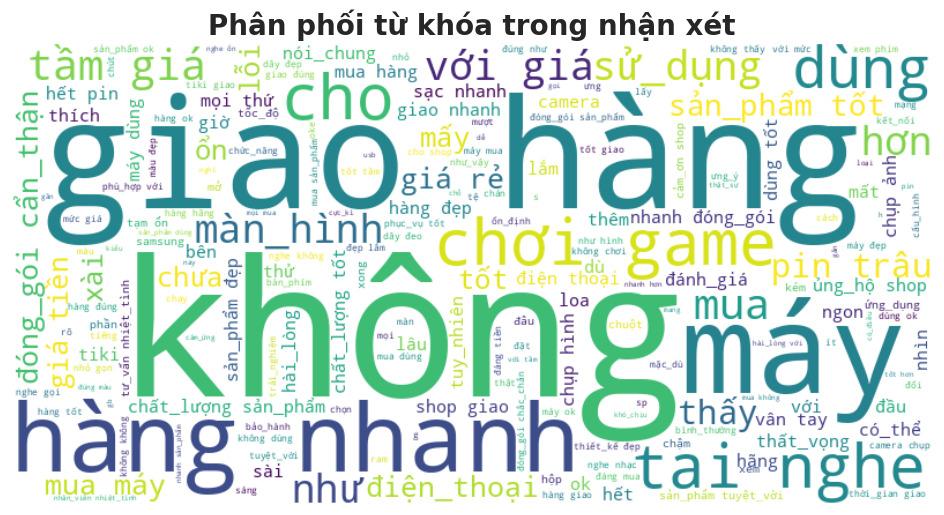

In [25]:
from wordcloud import WordCloud

# Tạo một chuỗi từ tất cả các nhận xét
text = ' '.join(data['cleaned_data'])

# Tạo Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Vẽ Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Không hiển thị trục
plt.title('Phân phối từ khóa trong nhận xét', fontsize=20, fontweight='bold')
plt.show()


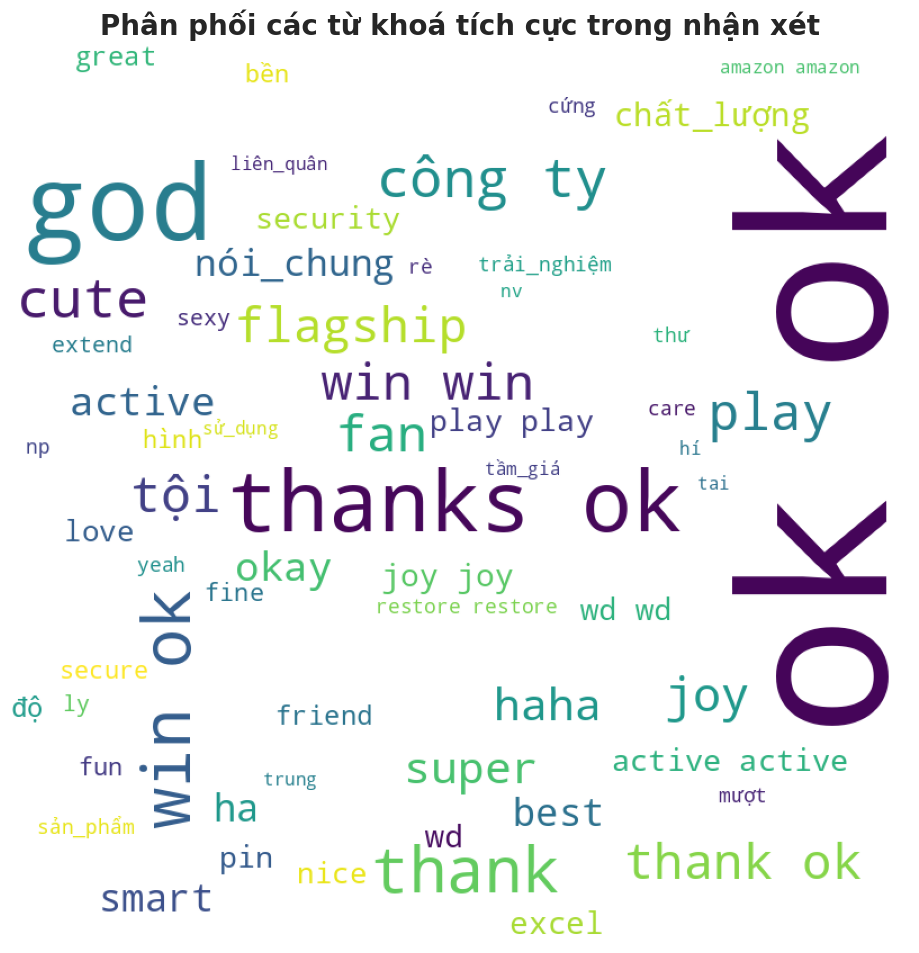

In [26]:
#Generating Word Cloud using postitve words list.
from wordcloud import WordCloud
comment_words = ' '
for words in pos_word_list:
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words=300,
                min_font_size = 15).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (9,12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Phân phối các từ khoá tích cực trong nhận xét', fontsize=20, fontweight='bold')

plt.show()

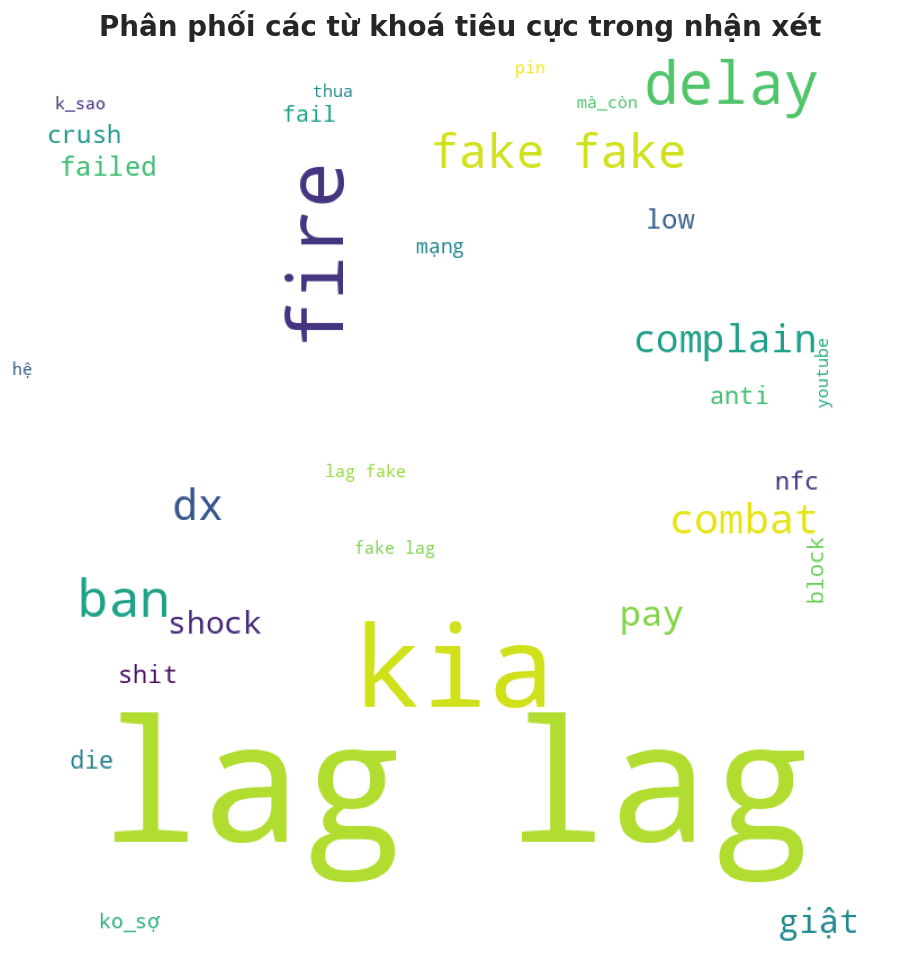

In [27]:
#Generating Word Cloud using negative words list.
comment_words = ' '
for words in neg_word_list:
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words=300,
                min_font_size = 15).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (12,9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Phân phối các từ khoá tiêu cực trong nhận xét', fontsize=20, fontweight='bold')

plt.show()

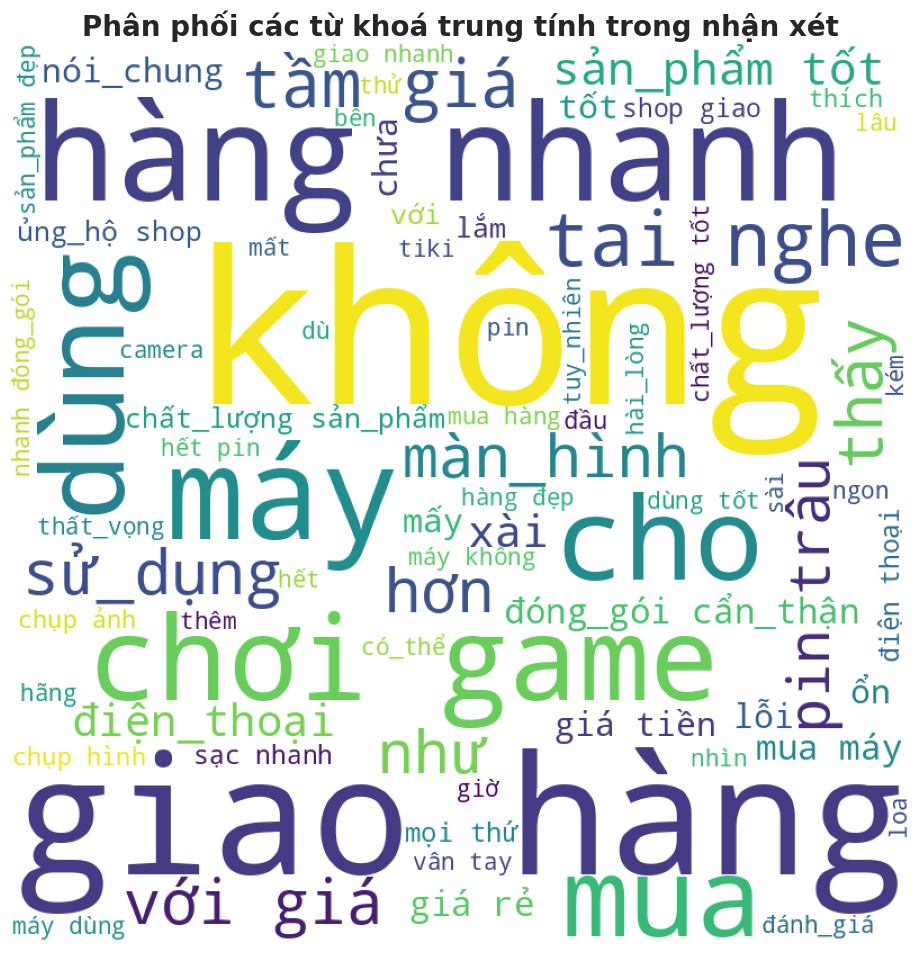

In [28]:
#Generating Word Cloud using negative words list.
comment_words = ' '
for words in neu_word_list:
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words=300,
                min_font_size = 15).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (12,9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Phân phối các từ khoá trung tính trong nhận xét', fontsize=20, fontweight='bold')

plt.show()

Dữ liệu hiện tại có sự mất cân bằng rõ rệt giữa các nhãn cảm xúc. Cụ thể, một số nhãn như 0, 2, 3, 4 và 5 có số lượng mẫu khá thấp so với nhãn 1. Việc này có thể gây khó khăn cho mô hình học tốt các nhãn hiếm, dẫn đến hiện tượng overfitting với các nhãn phổ biến và underfitting với nhãn ít dữ liệu.

Do đó, để giảm độ mất cân bằng và tăng độ khái quát cho mô hình, ta thực hiện gộp nhóm lại các nhãn có ý nghĩa cảm xúc tương đương:

- Label 0: Tiêu cực (Không hài lòng, lỗi) → Giữ nguyên là Tiêu cực.
- Label 1: Tích cực (Hài lòng, ổn) → Giữ nguyên là Tích cực.
- Label 2, 3, 4, 5: Các đánh giá có cả ưu và nhược điểm, yêu cầu hỗ trợ hoặc mang tính khen ngợi đặc biệt → Gộp chung thành một nhãn mới: "Trung tính".

Việc gộp này giúp phân loại theo 3 mức cảm xúc chính:
Tiêu cực, Trung tính, Tích cực — giúp mô hình dễ học hơn và giảm thiểu hiện tượng thiên lệch dữ liệu.

In [29]:
# Gộp nhãn cảm xúc thành 3 nhóm: Tiêu cực (0), Trung tính (1), Tích cực (2)
def merge_labels(label):
    if label == 0:
        return 0  # Tiêu cực
    elif label == 1:
        return 2  # Tích cực
    else:
        return 1  # Có lỗi nhỏ

# Thay thế cột label cũ bằng nhãn đã gộp
data['label'] = data['label'].apply(merge_labels)

# Kiểm tra phân bố sau khi gộp
print(data['label'].value_counts().sort_index())


label
0     4074
1     7925
2    14907
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



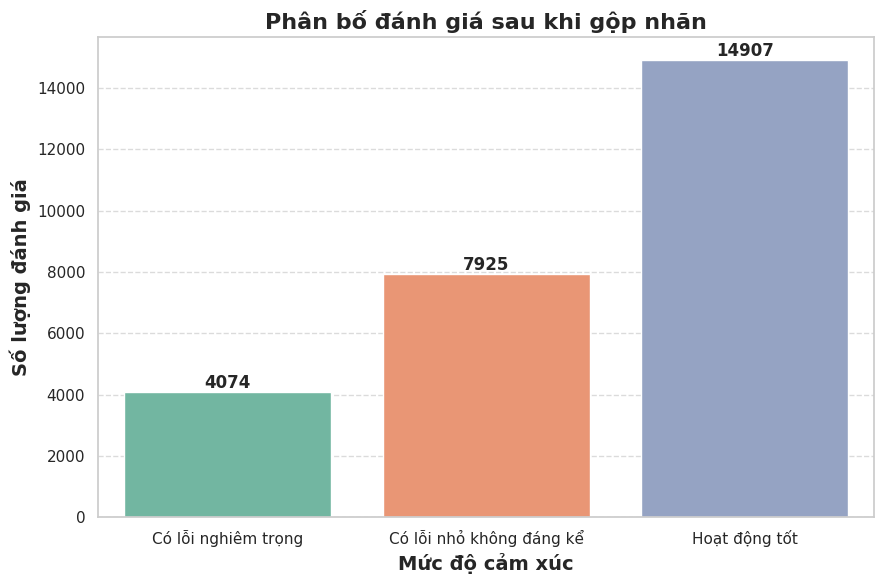

In [30]:
# Mô tả nhãn mới sau khi gộp
label_descriptions = {
    0: "Có lỗi nghiêm trọng",
    1: "Có lỗi nhỏ không đáng kể",
    2: "Hoạt động tốt"
}

# Đếm số lượng theo nhãn mới
label_counts = data['label'].value_counts().sort_index()
labels = [label_descriptions[i] for i in label_counts.index]

# Thiết lập style
sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))

# Vẽ biểu đồ
bar_plot = sns.barplot(x=labels, y=label_counts.values, palette='Set2')

# Nhãn trục và tiêu đề
plt.xlabel('Mức độ cảm xúc', fontsize=14, fontweight='bold')
plt.ylabel('Số lượng đánh giá', fontsize=14, fontweight='bold')
plt.title('Phân bố đánh giá sau khi gộp nhãn', fontsize=16, fontweight='bold')

# Hiển thị số lượng trên mỗi cột
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom',
                      fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
output_file = 'final_data.xlsx'

try:
    data.to_excel(output_file, index=False)
    logging.info(f"Lưu dữ liệu đã xử lý vào: {output_file}")
except Exception as e:
    logging.error(f"Lỗi khi lưu dữ liệu: {e}")